## Section 1: Business Understanding
Everything is about supply and demand in economy. So when I got the dataset of Airbnb in Boston, I was curious whether I can draw a supply-and-demand curve based on the dataset. 

Questions I'm interested in are:
- Q1: Is there any relationship between Airbnb house price and availability?
- Q2: Is it possible to have a model to predict the availability using the information in Airbnb dataset?
- Q3: What are the biggest differences between vacancy houses and hot ones?

## Section 2: Data Understanding (Access and Explore)

Import third-party libraries needed and the custom functions in each step.

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from steps.explore import format_calendar_data
from steps.clean import clean_listings_data
from steps.random_forest import optimize_param
from steps.hypo_test import fisher_test, mannwhitneyu_test

%matplotlib inline

### gather & access data

Load calendar.csv and plot it.

In [2]:
# 1. Explore the relationship between availability and price
calendar = pd.read_csv('./dataset/Boston/calendar.csv')
calendar.head()
print(calendar.shape, calendar.info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
(1308890, 4) None


This calnedar dataset has 4 columns with 1308890 rows, but for price column we need to convert it to float and for available we need to calulate the availability.

### clean and visualize
visualize calendar dataset

(array([1.073e+03, 8.450e+02, 5.290e+02, 2.690e+02, 1.110e+02, 4.400e+01,
        1.700e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 25. , 122.4, 219.8, 317.2, 414.6, 512. , 609.4, 706.8, 804.2,
        901.6, 999. ]),
 <BarContainer object of 10 artists>)

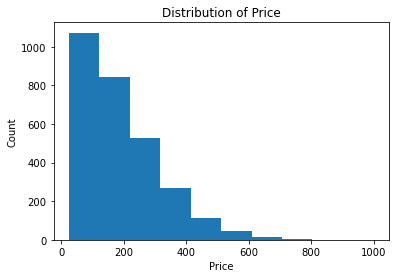

In [3]:
# format the price column to numeric value, use log to normalize price value and exclude outliners
price_available_rate = format_calendar_data(calendar)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.hist(price_available_rate['price_num'])

Seems the price data is right-skewed, let's draw a dot plot to see the relationship between price and availability

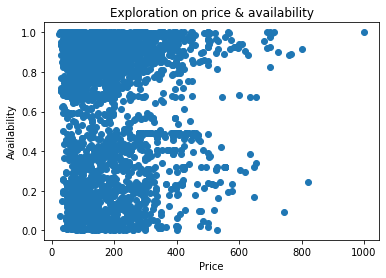

In [4]:
plt.scatter(price_available_rate['price_num'], price_available_rate['available_num'])
plt.xlabel('Price')
plt.ylabel('Availability')
plt.title('Exploration on price & availability')
plt.savefig("images/explore.jpg")

Seems the relationship between price and availability is not linear, we cannot say the more expensive a property is, the fewer people book it. Since the variance of price is large, we use the log x-axis instead.

               price_num_log  available_num
price_num_log       1.000000      -0.030366
available_num      -0.030366       1.000000


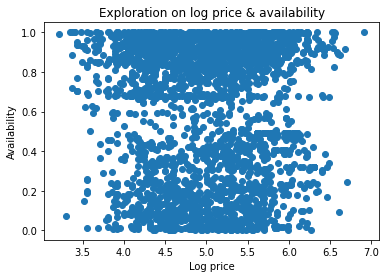

In [5]:
plt.scatter(price_available_rate['price_num_log'], price_available_rate['available_num'])
plt.xlabel('Log price')
plt.ylabel('Availability')
plt.title('Exploration on log price & availability')
plt.savefig("images/explore-log.jpg")
print(price_available_rate[['price_num_log', 'available_num']].corr())

Clearly price and availability are not strongly linear related. By the way, the dots are clearly split into two groups along the y-axis, few dots spot around 0.5 availability.

### gather & access data

Now, load the listing.csv dataset.

In [23]:
listings = pd.read_csv('./dataset/Boston/listings.csv')
listings.info()
missing_na_cols = listings.columns[listings.isna().any()]
print('\nnumber of columns that have NA:', len(missing_na_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

There are 44 columns with missing values, data cleaning and NA filling is needed. 

## Section 3:  Data Preparation (Cleaning)

Since there are 95 columns in the dataset, data cleaning is needed. After cleaning is done, save the dataframe into csv file for further studies.

### clean data

In the ```clean_listings_data``` function, cleaning steps are:
- drop columns that values are all missing
- dropping redundant columns, including ids(host_id), urls(medium_url), columns with only one value(last_scraped), long texts that is too complex to analyze(summary) and duplicated columns(availability_30, availability_60, availability_90).
- since boolean values in the dataset are coded as 't' and 'f', we need to convert them to True/False
- convert numeric values like currency and percentage digits to int/float type by stripping necessary prefix($) or suffix(%) strings.
- convert some numeric values that are not evenly distributed(host_response_rate) into categorical values.
- fill na rows with mean(review scores), 1(rooms), 0(reviews per month when there's no review), mode(host response time)
- process zipcode column, create zipcode_median_price (since there are outliners for price) for each zipcode(area) and try to normalize the price to get rid of the location factor as relative_zipcode_price
- convert amenities column into flatten columns
- wrap up and generate dummy columns

for more info, you can dive into ```steps/clean.py``` and check the comments

In [7]:
listings = clean_listings_data(listings)
# save data to 
listings.to_csv("./dataset/boston_data_formatted.csv", encoding="utf_8_sig")

## Section 4: Modelling

Split the dataset(3585 rows) into training and testing subsets. Try to predict the availability using price and other factors using LinearRegression model.

In [8]:
listings_X = listings.drop(['id', 'availability'], axis=1)
listings_y = listings['availability']
X_train, X_test, y_train, y_test = train_test_split(
    listings_X, listings_y, test_size=.2)

linear_model_sm = sm.OLS(y_train,sm.tools.add_constant(X_train).astype(float))
results_sm = linear_model_sm.fit()
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           availability   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     9.435
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          6.18e-151
Time:                        18:35:27   Log-Likelihood:                -786.63
No. Observations:                2868   AIC:                             1859.
Df Residuals:                    2725   BIC:                             2712.
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Since R-squared score for the linear model is 0.339 which is not good enough, there might be strong multicollinearity problems. So let's try random forest model instead. Get the suitable tree number first.

### Visualize

20  trees
0.9030603106097377

30  trees
0.906749794381396

50  trees
0.9134646829448057

100  trees
0.9163651098661802

200  trees
0.918615110303384

500  trees
0.919947736665518

1000  trees
0.9205729610885044



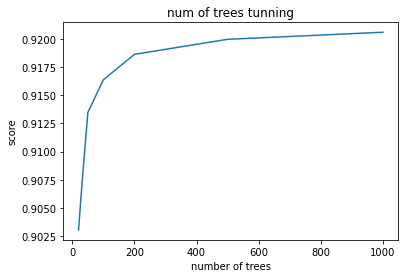

In [9]:
optimize_param(X_train, y_train)

The score on training data is pretty satisfactoring, over 0.91 when only 500 trees. Try to fit the model and have a plot.

In [10]:
rf_regressor = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features='auto')
rf_regressor.fit(X_train,y_train)
pred_y = rf_regressor.predict(X_test)

## Section 5: Evaluation
### visulize the random forest model

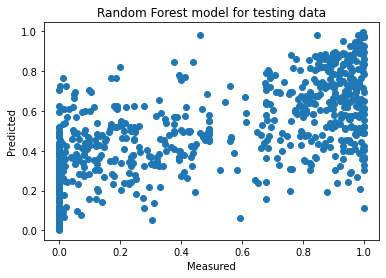

0.42964100628757784

In [11]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred_y)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Random Forest model for testing data')
plt.savefig("images/model.jpg")
plt.show()
rf_regressor.score(X_test,y_test)

The score is still low on test dataset but higher than linear regression model.

Since the price of dataset is grouped into two, a hypothesis test can be done between those vacancy properties and popular ones on each columns to see which columns are significantly different.

Firstly, split the dataset into two and look for the features that differs most between the two groups

### analyze

In [12]:
listings_low = listings[listings['availability'] < 0.5]
listings_high = listings[listings['availability'] >= 0.5]

For dummy columns, use fisher exact test and for numeric columns, use Mann-Whitney U test.

In [13]:
dummy_cols = listings.select_dtypes(include=['uint8', 'bool']).columns
numeric_cols = listings.drop(['id', 'availability'], axis=1).select_dtypes(include=['int', 'float']).columns
dummy_pval_high = fisher_test(listings_high, listings_low, columns=dummy_cols, alternative='greater')
dummy_pval_low = fisher_test(listings_high, listings_low, columns=dummy_cols, alternative='less')
numeric_pval_high = mannwhitneyu_test(listings_high, listings_low, columns=numeric_cols, alternative='greater')
numeric_pval_low = mannwhitneyu_test(listings_high, listings_low, columns=numeric_cols, alternative='less')

print(dummy_pval_high.sort_values())
print('')
print(dummy_pval_low.sort_values())
print('')
print(numeric_pval_high.sort_values())
print('')
print(numeric_pval_low.sort_values())


cancellation_policy_super_strict_30    6.772741e-23
host_about                             3.099518e-18
host_response_time_within an hour      9.874845e-15
property_type_House                    1.636632e-13
neighbourhood_cleansed_Dorchester      1.476822e-12
access                                 3.705482e-11
cancellation_policy_strict             1.113465e-10
notes                                  8.246343e-10
require_guest_phone_verification       1.410842e-07
amenities_Free_Parking_on_Premises     1.962251e-07
host_response_rate_MEDIUM              2.916042e-07
house_rules_LONG                       3.471529e-07
property_type_Bed & Breakfast          2.102175e-05
require_guest_profile_picture          2.149809e-04
host_is_superhost                      3.921017e-04
neighborhood_overview                  8.021362e-04
neighbourhood_cleansed_Roslindale      9.307441e-04
neighbourhood_cleansed_Mattapan        1.937062e-03
property_type_Boat                     2.206857e-03
host_accepta

### analyze

It shows that strict **cancellation policy**, **requirement for guest’s phone verification**, **long house rules** are significant higher in vacancy properties. And those properties that are relatively **old**(high host_since), **hosted by superhost**(high host_listing_count) and **of high extra fees**(high extra_people, high cleaning_fee, high security_deposite) are less popular.

On the opposite, **flexible cancellation policy**, **neighborhood to Fenway/Allston** may be essential for popular properties and they have also significantly **higher scores in value, rating and accuracy reviewing**. Besides, **average pricing for the area** is also higher for popular properties(just like Fenway/Allston/Mission Hill/Chinatown), which could indicate that the even with higher price for renting a property in urban areas, availability there is still higher than rural areas.


## Section 6: Deployment
Result are posted on Medium: https://medium.com/@cenkai29/exploratory-data-analysis-on-airbnb-availability-in-boston-500fb4b401c5